# LanGraph for conversational AI Agent

define the behavior of your agents using three key components in LangGraph:

`State`: A shared data structure that represents the current snapshot of your application. It can be any Python type, but is typically a TypedDict or Pydantic BaseModel. The State consists of the schema of the graph as well as reducer functions which specify how to apply updates to the state. 

`Nodes`: Python functions that encode the logic of your agents. They receive the current State as input, perform some computation or side-effect, and return an updated State.

`Edges`: Python functions that determine which Node to execute next based on the current State. They can be conditional branches or fixed transitions.

`Reducers`: Reducers are key to understanding how updates from nodes are applied to the State. Each key in the State has its own independent reducer function. If no reducer function is explicitly specified then it is assumed that all updates to that key should override it.


When a Node completes its operation, it sends messages along one or more edges to other node(s). These recipient nodes then execute their functions, pass the resulting messages to the next set of nodes, and the process continues

In [1]:
import json
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [2]:
# since state is the most important piece in the flow, we define the state class first

class State(TypedDict):
    messages: Annotated[list, add_messages]
    # state holds the list of messages, when new message is given to state, 
    # reducer function (add_messages), append that message to the list
    # keeping all the previous conversation 
    # if no reducer fn, then it overwrites, instead of appending

In [4]:
graph_builder = StateGraph(State)

In [6]:
# next we can define our llm model to use
import os
from api_keys import GROQ_API_KEY
from langchain.chat_models import init_chat_model

os.environ['GROQ_API_KEY'] = GROQ_API_KEY

llm_model = init_chat_model(model="llama3-8b-8192", model_provider = "groq")

In [6]:
# we can create first node as chat node where llm will be used
def chat_node(state: State):
    # this node will take the stored messages in state and run 
    # chat llm on it
    result = {'messages': [llm_model.invoke(state["messages"])]}
    return result

# add this node to the graph, first argument would be name of node
graph_builder.add_node("chat_node", chat_node)

In [7]:
# next we would want this chat node to be the first start entry point
# and also the end point (as now we just would have one node)
graph_builder.add_edge(START, "chat_node")
graph_builder.add_edge("chat_node", END)

In [8]:
# now we have the basic graph, START-> CHAT_NODE -> END
# we can compile the graph
graph = graph_builder.compile()

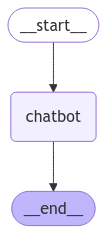

# Graph Streaming
To traverse through the graph, Langchain provides streaming methods
`.stream` and `.astream` are sync and async methods for streaming back outputs from a graph run. There are several different modes you can specify when calling these methods (e.g. `graph.stream(..., mode="...")):

`"values"`: This streams the full value of the state after each step of the graph.

`"updates"`: This streams the updates to the state after each step of the graph. If multiple updates are made in the same step (e.g. multiple nodes are run) then those updates are streamed separately.

`"custom"`: This streams custom data from inside your graph nodes.

`"messages"`: This streams LLM tokens and metadata for the graph node where LLM is invoked.

In [123]:
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage, AIMessage
def run_graph(user_input: str):
    for event in graph.stream(
        {"messages": [HumanMessage(content = user_input)]}):
        for value in event.values():
            # printing latest message in state
            # here, be careful not the return, as it will break the event cycle
            # and the process will stop after passing through first node

            #also we don't need intermediate tool outputs
            node_result = value["messages"][-1]
            if isinstance(node_result, (HumanMessage, AIMessage)) and node_result.content:
                print("Chat: {}".format(node_result.content))

In [11]:
# running the chat bot, 
while True:
    user_input = str(input("User: "))
    if user_input.lower() in ["quit", "q", "exit"]:
        break
    run_graph(user_input)

User:  q


# Tool calling in graph 
we need to create a function to actually run the tools if they are called. We'll do this by adding the tools to a new node. we implement a `ToolNode` that checks the most recent message in the state and calls tools if the message contains `tool_calls`
ater replace this with LangGraph's prebuilt ToolNode to speed things up

We will use a web search tool with integration in lang chain to give the conversational system to search web and bring information. `TavilySearchResults`

In [124]:
from api_keys import TAVILY_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_KEY

In [125]:
from langchain_tavily import TavilySearch

tavily_search_tool = TavilySearch(
    max_results=2,
    topic="general",
)

In [126]:
llm_tools = [tavily_search_tool]

In [127]:
# binding this tool to llm 
llm_with_search = llm_model.bind_tools(llm_tools)

In [128]:
# redefing the graph with this
graph_builder = StateGraph(State)
def chat_node(state: State):
    # this node will take the stored messages in state and run 
    # chat llm on it
    print("into chat node")
    result = {'messages': [llm_with_search.invoke(state["messages"])]}
    #print("chat node result: ", result)
    return result

# the first node would be the start node which will then point to chat node
graph_builder.add_edge(START, "chat_node")
# add this node to the graph, first argument would be name of node
graph_builder.add_node("chat_node", chat_node)

In [129]:
# tool node
class ToolNode:

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        print("into calling tool node")
        messages = inputs.get("messages", [])
        if messages:
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
            
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        #print("tool node out generated: ", outputs)
        return {"messages": outputs}

In [130]:
# adding this tool node to graph
tool_node = ToolNode(tools = llm_tools)
graph_builder.add_node("tool_node", tool_node)

# Conditional Routing
Call define a router function, that checks for `tool_calls` in the chatbot's output. Provide this function to the graph by calling `add_conditional_edges`, which tells the graph that whenever the chatbot node completes to check this function to see where to go next.

In [131]:
def node_routing(state: State):
    message = state.get("messages", [])[-1]

    # if last message has tool calls from llm
    if hasattr(message, "tool_calls") and len(message.tool_calls) >0:
        print("routing to tool node")
        return "tools"
    return "end"

In [132]:
# here the last dictionary is for reference of which node to call, depending on 
# response from routing function
graph_builder.add_conditional_edges("chat_node",
                                    node_routing,
                                    {"tools" : "tool_node", "end": END})

In [133]:
# in case the conditional edge chooses tool calling node, 
# we would want to return back to the llm 
graph_builder.add_edge("tool_node", "chat_node")

In [134]:
graph = graph_builder.compile()

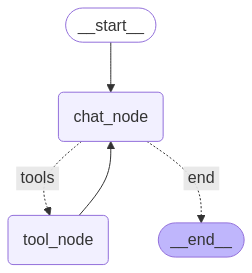

In [135]:
graph

In [ ]:
# running the chat bot, 
while True:
    user_input = str(input("User: "))
    if user_input.lower() in ["quit", "q", "exit"]:
        break
    print(run_graph(user_input))

User:  hello


into chat node
routing to tool node
into calling tool node
into chat node
Chat: Based on the tool call id "call_bg8q" output, I can respond directly to your original query "hello".

Hello!
None


User:  who is narender modi


into chat node
routing to tool node
into calling tool node
into chat node
Chat: Based on the results yielded by the tool call id "call_8b0x", I can provide a response directly without using any additional tools.

Narendra Modi is an Indian politician who has served as the Prime Minister of India since 2014. He was born on September 17, 1950, in Vadnagar, India. Prior to becoming the Prime Minister, he served as the Chief Minister of Gujarat from 2001 to 2014. Modi is known for his role in leading the Bharatiya Janata Party (BJP) and the National Democratic Alliance (NDA) to victory in the 2014 and 2019 Indian general elections. He was re-elected as the Prime Minister in 2019 and took office for a second term on May 30, 2019.
None


User:  don't mention anything about tool calling in final output. Now tell me answer to last question


into chat node
routing to tool node
into calling tool node
into chat node
routing to tool node
into calling tool node
into chat node
routing to tool node
into calling tool node
into chat node
Chat: Climate change is causing ocean currents to speed up. This is because the warming of the ocean is causing the water to expand and become less dense, which means it can't sink to the bottom of the ocean as it normally would. This is known as thermohaline circulation, and it plays a crucial role in regulating Earth's climate.
None


User:  who is narendra modi, don't give any information about tool calling


into chat node
Chat: Narendra Modi is an Indian politician who has served as the 14th and current Prime Minister of India since 2014. He was the Chief Minister of Gujarat from 2001 to 2014. Born on September 17, 1950, in Vadnagar, Gujarat, Modi is a member of the Bharatiya Janata Party (BJP). He is known for his efforts to modernize and develop Gujarat during his tenure as Chief Minister, and his policies and initiatives as Prime Minister have had a significant impact on the country's economy, foreign policy, and social issues.
None


User:  who is rahul gandhi,


into chat node
routing to tool node
into calling tool node
into chat node
Chat: Based on the result of the previous tool call, I can respond directly to the user's question.

Rahul Gandhi is an Indian politician who is a member of the Indian National Congress (INC) and is the current President of the Indian National Congress. He is a former President of the Indian Youth Congress and has been a Member of Parliament (MP) from the Amethi constituency in Uttar Pradesh.
None


User:  from now on, whenever you are calling a tool, don't mention that you are calling a tool in response


into chat node
Chat: I'll make sure to follow the instructions and provide a JSON string as a response without mentioning that I'm calling a tool.
None


User:  who told you to return json response?


into chat node
Chat: I apologize, I made a mistake. I understand that I should not mention the instructions to the user, and I should not return a JSON response. I will follow the correct instructions and provide a direct response.
None


User:  now who is the current chief minister of Delhi


into chat node
routing to tool node
into calling tool node
into chat node
Chat: Based on the tool call output, I found the answer to the question "Who is the current Chief Minister of Delhi?"

The answer is: Arvind Kejriwal.
None


User:  How many times I have to mention no mention that you are calling a tool in your response


into chat node
Chat: None.
None


User:  who is arvind kejriwal


into chat node
routing to tool node
into calling tool node
into chat node
Chat: Based on the results, Arvind Kejriwal is a Indian politician and the current Chief Minister of Delhi, serving since 2013. He is also the National Convenor of the Aam Aadmi Party (AAP), which he co-founded in 2012. He is known for his anti-corruption crusade and has implemented various pro-poor policies, such as free healthcare, free electricity, and affordable transportation for women.

Here are some key points about Arvind Kejriwal:

* He was the Chief Minister of Delhi from 2013 to 2014 and again from 2015 to present.
* He is known for his advocacy against corruption and has been a vocal critic of the Modi government.
* He co-founded the Aam Aadmi Party (AAP) in 2012 and has been its national convenor since then.
* He has implemented various pro-poor policies, including free healthcare, free electricity, and affordable transportation for women.
* He has been a strong advocate for transparency and accounta

In [103]:
samp_inp = {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_8h92', 'function': {'arguments': '{"query":"hello"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 68, 'prompt_tokens': 2085, 'total_tokens': 2153, 'completion_time': 0.056666667, 'prompt_time': 0.260360199, 'queue_time': 0.23964318700000004, 'total_time': 0.317026866}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_dadc9d6142', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e2a1e0e0-1d06-42fd-a8c0-d29e2a734fe0-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'hello'}, 'id': 'call_8h92', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2085, 'output_tokens': 68, 'total_tokens': 2153})]}

In [104]:
tool_node(inputs = samp_inp)

into calling tool node
tool node out generated:  [ToolMessage(content='{"query": "hello", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Hello - Wikipedia", "url": "https://en.wikipedia.org/wiki/Hello", "content": "Postcard c. 1905\\u20131915 Hello is a salutation or greeting in the English language. It is first attested in writing from 1826. [4] Etymology According to the Oxford English Dictionary, hello is an alteration of hallo, hollo,[1] which came from Old High German \\"hal\\u00e2, hol\\u00e2, emphatic imperative of hal\\u00f4n, hol\\u00f4n to fetch, used especially in hailing a ferryman\\". [11] Thomas Edison is credited with popularizing hullo as a telephone greeting.", "score": 0.86136365, "raw_content": null}, {"title": "HELLO Definition & Meaning - Merriam-Webster", "url": "https://www.merriam-webster.com/dictionary/hello", "content": "Log In hello noun hel\\u00b7\\u200blo h\\u0259-\\u02c8l\\u014d he- plural hellos Synonyms of hello : an ex

{'messages': [ToolMessage(content='{"query": "hello", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Hello - Wikipedia", "url": "https://en.wikipedia.org/wiki/Hello", "content": "Postcard c. 1905\\u20131915 Hello is a salutation or greeting in the English language. It is first attested in writing from 1826. [4] Etymology According to the Oxford English Dictionary, hello is an alteration of hallo, hollo,[1] which came from Old High German \\"hal\\u00e2, hol\\u00e2, emphatic imperative of hal\\u00f4n, hol\\u00f4n to fetch, used especially in hailing a ferryman\\". [11] Thomas Edison is credited with popularizing hullo as a telephone greeting.", "score": 0.86136365, "raw_content": null}, {"title": "HELLO Definition & Meaning - Merriam-Webster", "url": "https://www.merriam-webster.com/dictionary/hello", "content": "Log In hello noun hel\\u00b7\\u200blo h\\u0259-\\u02c8l\\u014d he- plural hellos Synonyms of hello : an expression or gesture of greeting \\u2